In [1]:
import os
print("Working Directory: " + str(os.path.realpath(os.getcwd() + '../../../')))

Working Directory: /home/diptesh/IEEE/src/drone


In [2]:
train_with_mask = '../../assets/Dataset/maskdata/maskdata/train/with_mask/'
train_without_mask = '../../assets/Dataset/maskdata/maskdata/train/without_mask'
test_with_mask = '../../assets/Dataset/maskdata/maskdata/test/with_mask'
test_without_mask = '../../assets/Dataset/maskdata/maskdata/test/without_mask'
print(len(os.listdir(train_with_mask)))
print(len(os.listdir(train_without_mask)))
print(len(os.listdir(test_with_mask)))
print(len(os.listdir(test_without_mask)))

2827
519
98
234


0
(224, 224)
1
(224, 224)
2
(224, 224)
3
(224, 224)
4
(224, 224)
5
(224, 224)


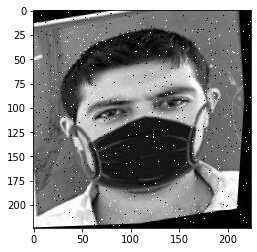

In [3]:
#import sys
from PIL import Image
import matplotlib.pyplot as plt

main_dir = train_with_mask
files = os.listdir(main_dir)
# you can change file extension below to read other image types
images_list = [i for i in files if i.endswith('.jpg')] ## output file names only
i = 0
for idx,image in enumerate(images_list):
  if i>5:
    break
  i = i + 1
  print(idx)
  img = Image.open(main_dir + image)
  print(img.size)
  plt.imshow(img)
  #img = img.resize((480, 600))

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Conv2D, Dense, Dropout, AveragePooling2D
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
#from tensorflow.keras.preprocessing.image import img_to_array
#from tensorflow.keras.models import load_model
#from tensorflow.keras.layers import Conv2D, MaxPool2D, Input
#from keras.applications import InceptionV3
#from tensorflow.keras.preprocessing.image import img_to_array
#from tensorflow.keras.preprocessing.image import load_img
#from tensorflow.keras.utils import to_categorical
#from sklearn.preprocessing import LabelBinarizer
#from sklearn.model_selection import train_test_split
#from imutils import paths
#import argparse

In [5]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [6]:
train_DIR = '../../assets/Dataset/maskdata/maskdata/train'
test_DIR = '../../assets/Dataset/maskdata/maskdata/test'

# Image_gen = ImageDataGenerator(rescale=1.0/255.0,
#                                horizontal_flip = True,
#                                rotation_range = 50,
#                                width_shift_range = 0.2,
#                                height_shift_range = 0.2,
#                                zoom_range = 0.2,
#                                fill_mode = 'nearest',
#                                validation_split = 0.2)

Image_gen = ImageDataGenerator(rescale=1.0/255.0,width_shift_range = 0.2,height_shift_range = 0.2,zoom_range = 0.2, fill_mode = 'nearest',validation_split = 0.2 )

train_generator = Image_gen.flow_from_directory(train_DIR,color_mode='rgb',
                                                target_size = (224,224),
                                                batch_size = 20,
                                                class_mode = 'categorical',
                                                subset = "training")

val_generator = Image_gen.flow_from_directory(train_DIR,color_mode='rgb',
                                                target_size = (224,224),
                                                batch_size = 20,
                                                class_mode = 'categorical',
                                                subset = "validation")

test_generator = Image_gen.flow_from_directory(test_DIR,color_mode='rgb',
                                                target_size = (224,224),
                                                batch_size = 20,
                                                class_mode = 'categorical',
                                                )

print(train_generator.image_shape)
print(val_generator.image_shape)
print(test_generator.image_shape)


Found 2678 images belonging to 2 classes.
Found 668 images belonging to 2 classes.
Found 332 images belonging to 2 classes.
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [7]:
input = keras.layers.Input(shape=(224,224,3))
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3), input_tensor= input)

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

In [8]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [9]:
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(train_generator, batch_size=BS, validation_data=val_generator, epochs=EPOCHS,verbose = 2)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
134/134 - 25s - loss: 0.3311 - accuracy: 0.8663 - val_loss: 0.1259 - val_accuracy: 0.9551
Epoch 2/20
134/134 - 24s - loss: 0.1192 - accuracy: 0.9552 - val_loss: 0.0888 - val_accuracy: 0.9671
Epoch 3/20
134/134 - 24s - loss: 0.0896 - accuracy: 0.9671 - val_loss: 0.0664 - val_accuracy: 0.9760
Epoch 4/20
134/134 - 25s - loss: 0.0601 - accuracy: 0.9768 - val_loss: 0.0652 - val_accuracy: 0.9760
Epoch 5/20
134/134 - 25s - loss: 0.0530 - accuracy: 0.9806 - val_loss: 0.0529 - val_accuracy: 0.9805
Epoch 6/20
134/134 - 25s - loss: 0.0442 - accuracy: 0.9869 - val_loss: 0.0507 - val_accuracy: 0.9790
Epoch 7/20
134/134 - 25s - loss: 0.0441 - accuracy: 0.9828 - val_loss: 0.0479 - val_accuracy: 0.9790
Epoch 8/20
134/134 - 25s - loss: 0.0354 - accuracy: 0.9892 - val_loss: 0.0565 - val_accuracy: 0.9746
Epoch 9/20
134/134 - 25s - loss: 0.0280 - accuracy: 0.9899 - val_loss: 0.0534 - val_accuracy: 0.9746
Epoch 10/20
134/134 - 25s - loss: 0.0298 

In [10]:
model.evaluate(test_generator,batch_size= BS, verbose=2)

17/17 - 2s - loss: 0.0380 - accuracy: 0.9819


[0.03803173452615738, 0.9819276928901672]

In [11]:
print("[INFO] evaluating network...")
predIdxs = model.predict(test_generator, batch_size=BS,verbose=2, )

predIdxs = np.argmax(predIdxs, axis=1)

[INFO] evaluating network...
17/17 - 2s


In [12]:
test_labels=test_generator.classes 
print(classification_report(test_labels, predIdxs))

              precision    recall  f1-score   support

           0       0.27      0.28      0.27        98
           1       0.69      0.69      0.69       234

    accuracy                           0.57       332
   macro avg       0.48      0.48      0.48       332
weighted avg       0.57      0.57      0.57       332



In [13]:
# model.save("../saved_model", save_format="h5")

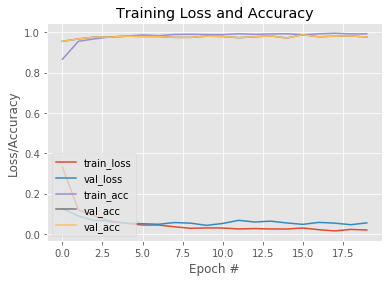

In [14]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

Mask:  0.99320084
Non Mask:  0.006799141


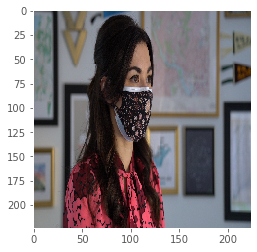

In [15]:
k = "../../assets/test_photos/7.jpg"
import cv2
from keras_preprocessing import image
images = image.load_img(k, target_size=(224, 224))
x1 = image.img_to_array(images)
#x1 = image.rgb_to_grayscale(x1)
x = np.expand_dims(x1, axis=0)
x = x/255.0
plt.imshow(images)
plt.grid(None)
k = model.predict(x)
print("Mask: ",k[0][0])
print("Non Mask: ",k[0][1])

In [16]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype, name="yourInputName"))
# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 50)
print("Frozen model layers: ")
for layer in layers:
    print(layer)
print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)
# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="../frozen_models",
                  name="frozen_graph.pb",
                  as_text=False)

--------------------------------------------------
Frozen model layers: 
yourInputName
functional_1/Conv1_pad/Pad/paddings
functional_1/Conv1_pad/Pad
functional_1/Conv1/Conv2D/ReadVariableOp/resource
functional_1/Conv1/Conv2D/ReadVariableOp
functional_1/Conv1/Conv2D
functional_1/bn_Conv1/ReadVariableOp/resource
functional_1/bn_Conv1/ReadVariableOp
functional_1/bn_Conv1/ReadVariableOp_1/resource
functional_1/bn_Conv1/ReadVariableOp_1
functional_1/bn_Conv1/FusedBatchNormV3/ReadVariableOp/resource
functional_1/bn_Conv1/FusedBatchNormV3/ReadVariableOp
functional_1/bn_Conv1/FusedBatchNormV3/ReadVariableOp_1/resource
functional_1/bn_Conv1/FusedBatchNormV3/ReadVariableOp_1
functional_1/bn_Conv1/FusedBatchNormV3
functional_1/Conv1_relu/Relu6
functional_1/expanded_conv_depthwise/depthwise/ReadVariableOp/resource
functional_1/expanded_conv_depthwise/depthwise/ReadVariableOp
functional_1/expanded_conv_depthwise/depthwise
functional_1/expanded_conv_depthwise_BN/ReadVariableOp/resource
functional_1

'../frozen_models/frozen_graph.pb'

In [17]:
pb_file = '../frozen_models/frozen_graph.pb'
graph_def = tf.compat.v1.GraphDef()

try:
    with tf.io.gfile.GFile(pb_file, 'rb') as f:
        graph_def.ParseFromString(f.read())
except:
    with tf.gfile.FastGFile(pb_file, 'rb') as f:
        graph_def.ParseFromString(f.read())

# Delete weights
for i in reversed(range(len(graph_def.node))):
    if graph_def.node[i].op == 'Const':
        del graph_def.node[i]

graph_def.library.Clear()

tf.compat.v1.train.write_graph(graph_def, "../frozen_models", 'model.pbtxt', as_text=True)

'../frozen_models/model.pbtxt'

(183, 275, 3)
(183, 275, 3)
Non-mask:  0.006304144
Mask:  0.9936959


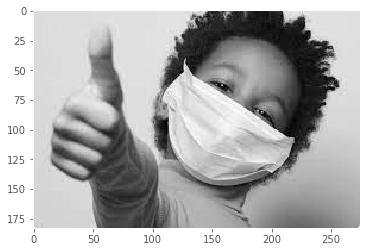

In [18]:
import cv2
import numpy as np
# Load a model imported from Tensorflow
tensorflowNet = cv2.dnn.readNetFromTensorflow('../frozen_models/frozen_graph.pb', '../frozen_models/model.pbtxt')
# Input image
img = cv2.imread('../../assets/test_photos/10.jpg', cv2.IMREAD_COLOR)
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #(224,224, 3) = (224,224, 1)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) #(224,224,1) = (224,224,3)
print(img.shape)
image = img.astype(np.float32)
rows, cols, channels = img.shape

mean = np.array([1.0, 1.0, 1.0]) * 127.5
scale = 1 / 127.5

# Use the given image as input, which needs to be blob(s).
blob = cv2.dnn.blobFromImage(image, scale, size=(224, 224), mean=mean, swapRB=True, crop=False)
tensorflowNet.setInput(blob)

# Runs a forward pass to compute the net output
networkOutput = tensorflowNet.forward()[0]
print("Non-mask: ", networkOutput[1])
print("Mask: ", networkOutput[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.grid(None)

# cv2.imshow('Image', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows() 